In [1]:
from google.colab import drive
from os import chdir, getcwd

drive.mount('/content/gdrive')
chdir("/content/gdrive/My Drive/SSD_ADAS/ssd_keras/")
print("Working directory:", getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Working directory: /content/gdrive/My Drive/SSD_ADAS/ssd_keras


In [2]:
from models.keras_ssd300 import ssd_300
from eval_utils.average_precision_evaluator import Evaluator

Using TensorFlow backend.


In [3]:
# Load validation data
from data_generator.object_detection_2d_data_generator import DataGenerator

input_format = ["image_name", "class_id", "xmin", "xmax", "ymin", "ymax"] # order of columns in the annotation csv
validation_image_dir = "../FLIR_ADAS/validation/PreviewData"
validation_annotation_csv = "../validation.csv"

validation_dataset = DataGenerator()
validation_dataset.parse_csv(
    validation_image_dir,
    validation_annotation_csv,
    input_format
)

print("{} images in validation set.".format(validation_dataset.get_dataset_size()))

1360 images in validation set.


In [0]:
# Network parameters 

img_height = 300
img_width = 300
n_classes = 80 # COCO classes
scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05], # COCO
offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
model_mode = "training"

In [0]:
from keras import backend as K
from keras.models import load_model

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_loss_function.keras_ssd_loss import SSDLoss


def evaluate_ssd(h5_filename):
  #Clear previously loaded models
  K.clear_session()
  
  #Fill in the custom objects so that Keras can load the model
  ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
  
  custom_objects = {
      'AnchorBoxes': AnchorBoxes,
      'L2Normalization': L2Normalization,
      'DecodeDetections': DecodeDetections,
      'compute_loss': ssd_loss.compute_loss}
  
  #Load the model
  model = load_model(h5_filename, custom_objects)
  print("Model loaded:", h5_filename)
  
  #Evaluate the model on validation_dataset
  evaluator = Evaluator(
      model=model,
      n_classes=n_classes,
      data_generator=validation_dataset,
      model_mode=model_mode
  )
  
  results = evaluator(
      img_height=img_height,
      img_width=img_width,
      batch_size=64,
      matching_iou_threshold=0.5,
      average_precision_mode='integrate',
      return_precisions=True,
      return_recalls=True,
      return_average_precisions=True,
      verbose=True
  )
  
  #mean_average_precision, average_precisions, precisions, recalls = results
  
  return results

In [6]:
!ls *.h5

ssd300_alpha1_newaug_epoch-174_loss-3.7961_val_loss-3.3007.h5
ssd300_alpha1_newaug_epoch-175_loss-3.9203_val_loss-3.3743.h5
ssd300_alpha1_newaug_epoch-176_loss-3.9218_val_loss-3.3427.h5
ssd300_alpha1_newaug_epoch-179_loss-3.9354_val_loss-3.3120.h5
ssd300_alpha1_newaug_epoch-183_loss-3.8273_val_loss-3.3090.h5
ssd300_alpha1_newaug_epoch-184_loss-3.8187_val_loss-3.3009.h5
ssd300_alpha1_newaug_epoch-185_loss-3.8150_val_loss-3.2687.h5
ssd300_alpha1_newaug_epoch-188_loss-3.7672_val_loss-3.2388.h5
ssd300_alpha1_newaug_epoch-189_loss-3.8069_val_loss-3.2372.h5
ssd300_alpha1_newaug_epoch-194_loss-3.7543_val_loss-3.2210.h5
ssd300_alpha1_newaug_epoch-195_loss-3.7363_val_loss-3.2185.h5
ssd300_alpha1_newaug_epoch-196_loss-3.7262_val_loss-3.1950.h5
ssd300_alpha1_newaug_epoch-200_loss-3.7038_val_loss-3.1938.h5
ssd300_alpha1_newaug_epoch-201_loss-3.7243_val_loss-3.1838.h5
ssd300_alpha1_newaug_epoch-206_loss-3.6875_val_loss-3.1735.h5
ssd300_alpha4_epoch-121_loss-7.7476_val_loss-6.3080.h5
ssd300_alpha4_e

In [7]:
models_to_evaluate = [
    "ssd300_alpha1_newaug_epoch-174_loss-3.7961_val_loss-3.3007.h5",
    "ssd300_alpha1_newaug_epoch-206_loss-3.6875_val_loss-3.1735.h5"
]

results_list = list(map(evaluate_ssd, models_to_evaluate))

Model loaded: ssd300_alpha1_newaug_epoch-174_loss-3.7961_val_loss-3.3007.h5
Number of images in the evaluation dataset: 1360

Producing predictions batch-wise: 100%|██████████| 22/22 [1:13:06<00:00, 160.49s/it]
Matching predictions to ground truth, class 1/80.: 100%|██████████| 78906/78906 [00:09<00:00, 8331.19it/s]
Matching predictions to ground truth, class 2/80.: 100%|██████████| 11926/11926 [00:00<00:00, 15479.88it/s]
Matching predictions to ground truth, class 3/80.: 100%|██████████| 181168/181168 [00:21<00:00, 8375.38it/s]
No predictions for class 4/80
No predictions for class 5/80
No predictions for class 6/80
No predictions for class 7/80
No predictions for class 8/80
No predictions for class 9/80
No predictions for class 10/80
No predictions for class 11/80
No predictions for class 12/80
No predictions for class 13/80
No predictions for class 14/80
No predictions for class 15/80
No predictions for class 16/80
No predictions for class 17/80
No predictions for class 18/80
No pre

Model:  ssd300_alpha1_newaug_epoch-174_loss-3.7961_val_loss-3.3007.h5
person               AP: 0.19709034393944855 
bicycle              AP: 0.13082228829615758 
car                  AP: 0.5967358927731572 
dog                  AP: 0.0      
Main classes mAP: 0.3082161750029211

Model:  ssd300_alpha1_newaug_epoch-206_loss-3.6875_val_loss-3.1735.h5
person               AP: 0.20605076010598422 
bicycle              AP: 0.13939051110321624 
car                  AP: 0.5971818598555252 
dog                  AP: 0.0      
Main classes mAP: 0.3142077103549085



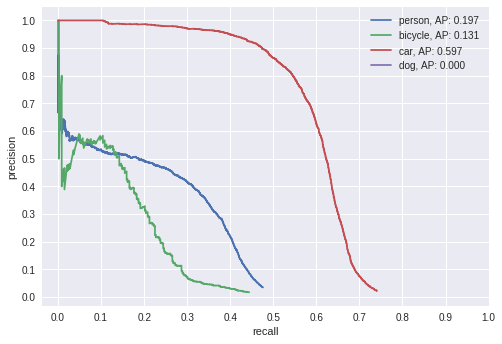

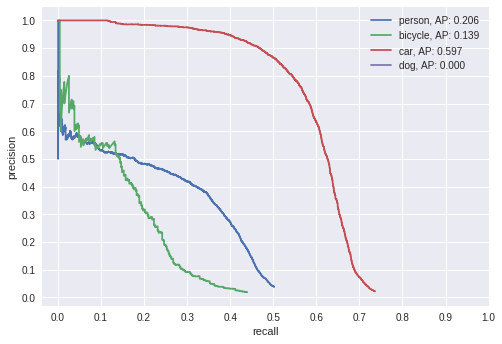

In [8]:
import matplotlib.pyplot as plt
import numpy as np

classes_of_interest = {1:"person", 2:"bicycle", 3:"car", 17:"dog"}

def summarize_results(results, model_name):
  mean_average_precision, average_precisions, precisions, recalls = results
  
  def plot_PRs(class_ids):
    plt.figure()
  
    for class_id in class_ids:
      plt.plot(
        recalls[class_id],
        precisions[class_id],
        label = "{}, AP: {:.3f}".format(classes_of_interest[class_id], average_precisions[class_id]))

    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    return

  def print_summary():
    for class_id in classes_of_interest.keys():
      print("{:<20} AP: {:<8} ".format(classes_of_interest[class_id], average_precisions[class_id]))
    
    main_classes_AP = np.mean((average_precisions[1], average_precisions[2], average_precisions[3]))
    print("Main classes mAP:", main_classes_AP)
    print()
    return

  print("Model: ", model_name)
  plot_PRs(classes_of_interest.keys())
  print_summary()
  
for (results, model_name) in zip(results_list, models_to_evaluate):
  summarize_results(results, model_name)
  